<a href="https://colab.research.google.com/github/shreyas1209/Stock-Market-Prediction/blob/main/Stock_Market_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('drive')

Mounted at drive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader,Dataset 
from torchvision import transforms
from torchvision import datasets
from math import *
from sklearn.metrics import mean_squared_error
%matplotlib inline


Loading Data for Google,Amazon and Apple Stocks

In [3]:
google_data = pd.read_csv('/content/drive/MyDrive/Stock_market_prediction/GOOGL_2006-01-01_to_2018-01-01.csv')
amazon_data = pd.read_csv('/content/drive/MyDrive/Stock_market_prediction/AMZN_2006-01-01_to_2018-01-01.csv')
apple_data = pd.read_csv('/content/drive/MyDrive/Stock_market_prediction/AAPL_2006-01-01_to_2018-01-01.csv')

In [4]:
print(google_data.shape)
google_data.head(5)

(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [5]:
print(amazon_data.shape)
amazon_data.head(5)

(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [6]:
print(apple_data.shape)
apple_data.head(5)

(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Plotting Data for stocks

In [7]:
google_close = google_data[['Close']]
amazon_close = amazon_data[['Close']]
apple_close  = apple_data[['Close']]

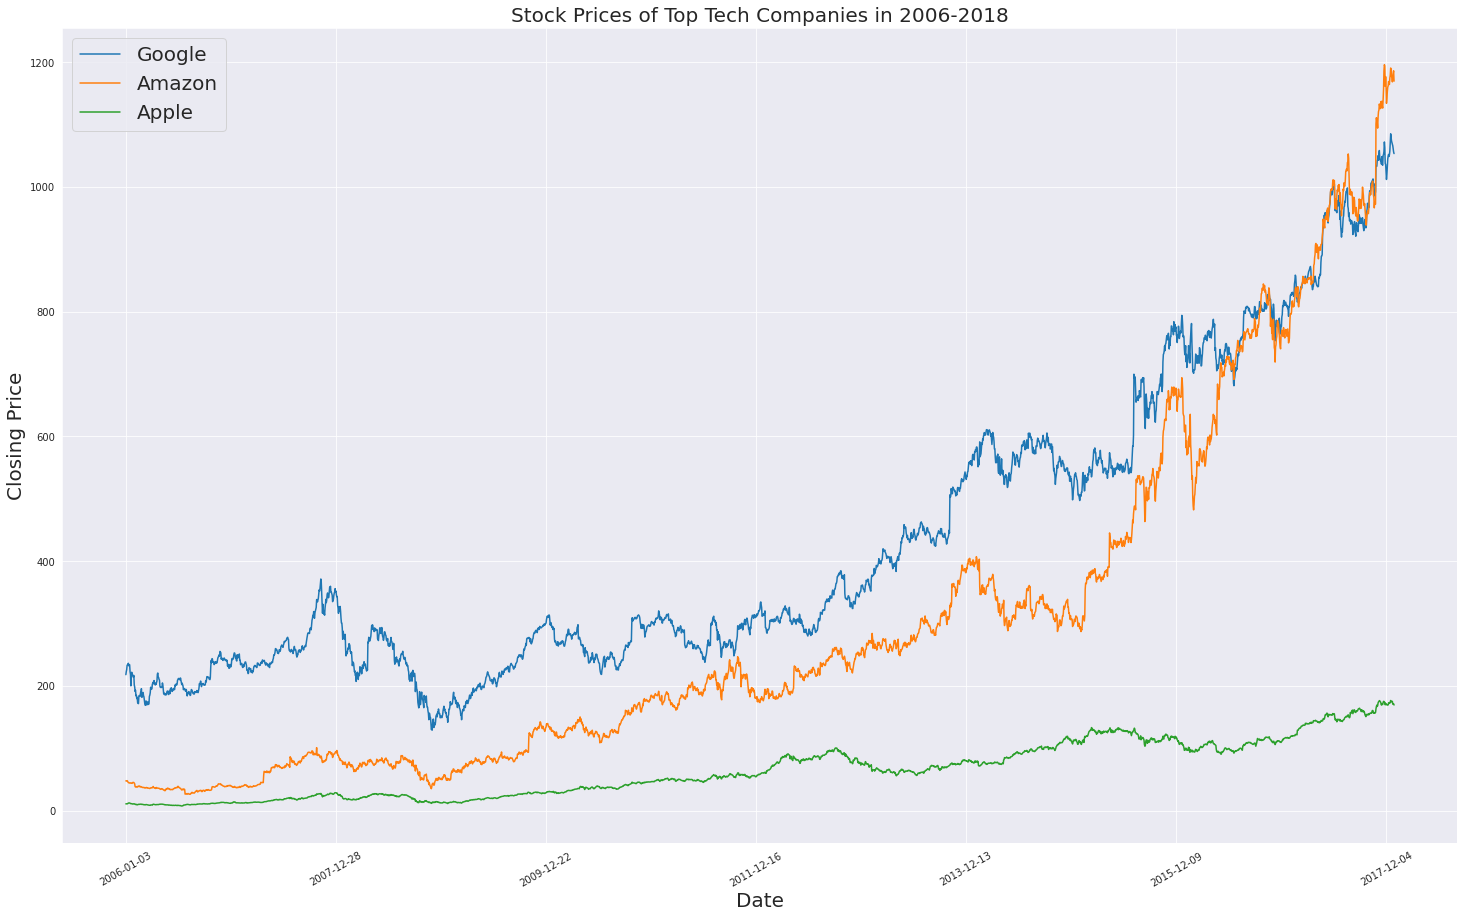

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize = (25,15))
plt.plot(google_close,label='Google')
plt.plot(amazon_close,label='Amazon')
plt.plot(apple_close,label ='Apple')
plt.xticks(range(0,google_data.shape[0],500),google_data['Date'].loc[::500],rotation=30)
plt.legend(prop={'size': 20})
plt.title("Stock Prices of Top Tech Companies in 2006-2018",fontdict={'fontsize':20})
plt.xlabel('Date',fontdict={'fontsize':20})
plt.ylabel('Closing Price',fontdict={'fontsize':20})
plt.show()


Normalizing the data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

google_close = scaler.fit_transform(google_close.values.reshape(-1,1))
amazon_close = scaler.fit_transform(amazon_close.values.reshape(-1,1))
apple_close = scaler.fit_transform(apple_close.values.reshape(-1,1))


Splitting the train and test data

In [10]:
#use of prior time steps to predict the next time step with window_width
def train_test_split(stock,window_width,train_split_pct):
  stock_data = []
  init_data_length = len(stock)

  for i in range(init_data_length-window_width):
    data_window = stock[i:i+window_width]
    stock_data.append(data_window)
  stock_data = np.array(stock_data)
  data_size = len(stock_data)
  train_size = int(np.round(data_size*train_split_pct))
  X_train = stock_data[:train_size,:-1,:]
  y_train = stock_data[:train_size,-1,:]
    
  X_test = stock_data[train_size:,:-1]
  y_test = stock_data[train_size:,-1,:]
    
  return (X_train, y_train, X_test, y_test)
   

Splitting data for all three companies

In [11]:
google_X_train,google_y_train,google_X_test, google_y_test = train_test_split(stock = google_close,
                                                                              window_width = 25,
                                                                              train_split_pct = 0.75,
                                                                              )
google_X_train = torch.from_numpy(google_X_train.astype(np.float32))
google_y_train = torch.from_numpy(google_y_train.astype(np.float32))
google_X_test = torch.from_numpy(google_X_test.astype(np.float32))
google_y_test = torch.from_numpy(google_y_test.astype(np.float32))
print('X_train.shape = ',google_X_train.shape)
print('y_train.shape = ',google_y_train.shape)
print('X_test.shape = ',google_X_test.shape)
print('y_test.shape = ',google_y_test.shape)

X_train.shape =  torch.Size([2246, 24, 1])
y_train.shape =  torch.Size([2246, 1])
X_test.shape =  torch.Size([748, 24, 1])
y_test.shape =  torch.Size([748, 1])


In [12]:
amazon_X_train,amazon_y_train,amazon_X_test, amazon_y_test = train_test_split(stock = amazon_close,
                                                                              window_width = 20,
                                                                              train_split_pct = 0.8,
                                                                              )
amazon_X_train = torch.from_numpy(amazon_X_train.astype(np.float32))
amazon_y_train = torch.from_numpy(amazon_y_train.astype(np.float32))
amazon_X_test = torch.from_numpy(amazon_X_test.astype(np.float32))
amazon_y_test = torch.from_numpy(amazon_y_test.astype(np.float32))
print('X_train.shape = ',amazon_X_train.shape)
print('y_train.shape = ',amazon_y_train.shape)
print('X_test.shape = ',amazon_X_test.shape)
print('y_test.shape = ',amazon_y_test.shape)

X_train.shape =  torch.Size([2399, 19, 1])
y_train.shape =  torch.Size([2399, 1])
X_test.shape =  torch.Size([600, 19, 1])
y_test.shape =  torch.Size([600, 1])


In [13]:
apple_X_train,apple_y_train,apple_X_test, apple_y_test = train_test_split(stock = apple_close,
                                                                              window_width = 20,
                                                                              train_split_pct = 0.8,
                                                                              )
apple_X_train = torch.from_numpy(apple_X_train.astype(np.float32))
apple_y_train = torch.from_numpy(apple_y_train.astype(np.float32))
apple_X_test = torch.from_numpy(apple_X_test.astype(np.float32))
apple_y_test = torch.from_numpy(apple_y_test.astype(np.float32))
print('X_train.shape = ',apple_X_train.shape)
print('y_train.shape = ',apple_y_train.shape)
print('X_test.shape = ',apple_X_test.shape)
print('y_test.shape = ',apple_y_test.shape)

X_train.shape =  torch.Size([2399, 19, 1])
y_train.shape =  torch.Size([2399, 1])
X_test.shape =  torch.Size([600, 19, 1])
y_test.shape =  torch.Size([600, 1])


In [14]:
import sys
sys.path.append('/content/drive/MyDrive/Stock_market_prediction/notebooks')
from stock_market_models import *
from stock_market_train import *

In [15]:
input_size = 1
hidden_size = 32
output_size = 1



In [16]:
model = LSTM(input_size = input_size,hidden_size = hidden_size,output_size = output_size)

In [17]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100

Training the data for Google

In [18]:
google_train_pred = train(google_X_train,google_y_train,model,loss_func,optimizer,epochs=100)

Epoch  1 Loss:  0.34453681111335754 Time:  0.49620330700000004
Epoch  2 Loss:  0.20826128125190735 Time:  0.38413285499999983
Epoch  3 Loss:  0.09690076112747192 Time:  0.34477402300000026
Epoch  4 Loss:  0.07432878017425537 Time:  0.357546138
Epoch  5 Loss:  0.07947759330272675 Time:  0.36121997899999947
Epoch  6 Loss:  0.05386659502983093 Time:  0.365168111
Epoch  7 Loss:  0.05523890256881714 Time:  0.35960765099999925
Epoch  8 Loss:  0.06128396466374397 Time:  0.3608026090000003
Epoch  9 Loss:  0.06090402230620384 Time:  0.3610495759999992
Epoch  10 Loss:  0.054189283400774 Time:  0.3381792009999991
Epoch  11 Loss:  0.04570252448320389 Time:  0.3363427699999999
Epoch  12 Loss:  0.04166671261191368 Time:  0.355646522999999
Epoch  13 Loss:  0.044526126235723495 Time:  0.3489734680000005
Epoch  14 Loss:  0.043525584042072296 Time:  0.33500998900000134
Epoch  15 Loss:  0.033336520195007324 Time:  0.3496089680000001
Epoch  16 Loss:  0.025646554306149483 Time:  0.33202158099999934
Epoch  

In [19]:
amazon_train_pred=train(amazon_X_train,amazon_y_train,model,loss_func,optimizer,epochs=100)

Epoch  1 Loss:  0.0004724490863736719 Time:  0.30867402499999486
Epoch  2 Loss:  0.0003031207306776196 Time:  0.29631989800000014
Epoch  3 Loss:  0.00042241092887707055 Time:  0.30677035899999794
Epoch  4 Loss:  0.0003705878334585577 Time:  0.30552329000000356
Epoch  5 Loss:  0.0002791413862723857 Time:  0.31160297199999576
Epoch  6 Loss:  0.0003841474826913327 Time:  0.3129333030000012
Epoch  7 Loss:  0.0003016853588633239 Time:  0.3250834179999984
Epoch  8 Loss:  0.0002828743599820882 Time:  0.32035139699999604
Epoch  9 Loss:  0.0003433234815020114 Time:  0.32950033499999876
Epoch  10 Loss:  0.0002509085461497307 Time:  0.30183056799999974
Epoch  11 Loss:  0.0002834841434378177 Time:  0.3059747140000013
Epoch  12 Loss:  0.0002814756298903376 Time:  0.30173392300000046
Epoch  13 Loss:  0.00022262096172198653 Time:  0.3034476380000015
Epoch  14 Loss:  0.00026789389085024595 Time:  0.3333098459999988
Epoch  15 Loss:  0.00023095992219168693 Time:  0.299169526
Epoch  16 Loss:  0.000221249

In [20]:

apple_train_pred=train(apple_X_train,apple_y_train,model,loss_func,optimizer,epochs=100)

Epoch  1 Loss:  0.005512498784810305 Time:  0.30349592400000347
Epoch  2 Loss:  0.003358064219355583 Time:  0.282684574000001
Epoch  3 Loss:  0.002149685751646757 Time:  0.2996951700000068
Epoch  4 Loss:  0.003762138308957219 Time:  0.30278917900000124
Epoch  5 Loss:  0.001864862279035151 Time:  0.29453563399999894
Epoch  6 Loss:  0.000961383106186986 Time:  0.3144826630000068
Epoch  7 Loss:  0.0021167423110455275 Time:  0.3243279969999975
Epoch  8 Loss:  0.0019591795280575752 Time:  0.3257107000000019
Epoch  9 Loss:  0.0013188448501750827 Time:  0.3049095539999911
Epoch  10 Loss:  0.00237600551918149 Time:  0.3014156630000002
Epoch  11 Loss:  0.0012348880991339684 Time:  0.29825373100000263
Epoch  12 Loss:  0.0011645249323919415 Time:  0.29642527500000426
Epoch  13 Loss:  0.0010702175786718726 Time:  0.29667664599999455
Epoch  14 Loss:  0.0008698730380274355 Time:  0.3023619649999887
Epoch  15 Loss:  0.0007740421569906175 Time:  0.2882532200000014
Epoch  16 Loss:  0.00108286552131176 

In [21]:

google_train_predict = pd.DataFrame(scaler.inverse_transform(google_train_pred.detach().numpy()))
amazon_train_predict = pd.DataFrame(scaler.inverse_transform(amazon_train_pred.detach().numpy()))
apple_train_predict = pd.DataFrame(scaler.inverse_transform(apple_train_pred.detach().numpy()))



In [22]:
google_close_train = pd.DataFrame(scaler.inverse_transform(google_y_train.detach().numpy()))
amazon_close_train = pd.DataFrame(scaler.inverse_transform(amazon_y_train.detach().numpy()))
apple_close_train = pd.DataFrame(scaler.inverse_transform(apple_y_train.detach().numpy()))

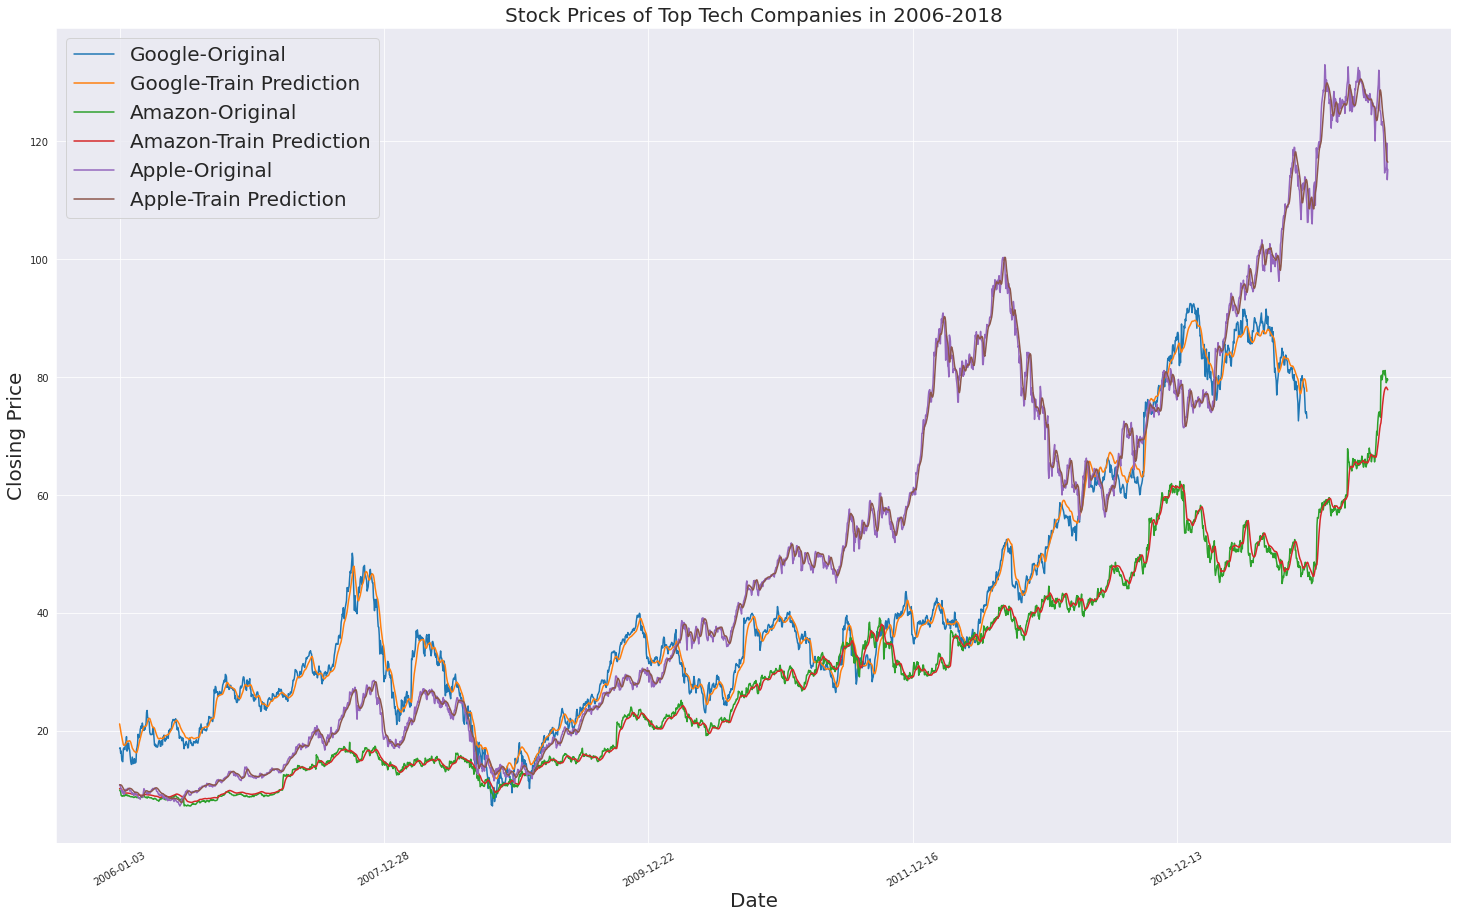

In [23]:
sns.set_style("darkgrid")
plt.figure(figsize = (25,15))
plt.plot(google_close_train,label='Google-Original')
plt.plot(google_train_predict,label='Google-Train Prediction')

plt.plot(amazon_close_train,label='Amazon-Original')
plt.plot(amazon_train_predict,label='Amazon-Train Prediction')


plt.plot(apple_close_train,label ='Apple-Original')
plt.plot(apple_train_predict,label ='Apple-Train Prediction')

plt.xticks(range(0,google_close_train.shape[0],500),google_data['Date'].loc[::500],rotation=30)
plt.legend(prop={'size': 20})
plt.title("Stock Prices of Top Tech Companies in 2006-2018",fontdict={'fontsize':20})
plt.xlabel('Date',fontdict={'fontsize':20})
plt.ylabel('Closing Price',fontdict={'fontsize':20})
plt.show()

Predicting on the test data

In [24]:
google_test_pred = model(google_X_test)
amazon_test_pred = model(amazon_X_test)
apple_test_pred = model(apple_X_test)


In [25]:
google_test_predict = pd.DataFrame(scaler.inverse_transform(google_test_pred.detach().numpy()))
amazon_test_predict = pd.DataFrame(scaler.inverse_transform(amazon_test_pred.detach().numpy()))
apple_test_predict = pd.DataFrame(scaler.inverse_transform(apple_test_pred.detach().numpy()))


In [26]:
google_close_test = pd.DataFrame(scaler.inverse_transform(google_y_test.detach().numpy()))
amazon_close_test = pd.DataFrame(scaler.inverse_transform(amazon_y_test.detach().numpy()))
apple_close_test = pd.DataFrame(scaler.inverse_transform(apple_y_test.detach().numpy()))


In [27]:
google_train_score = sqrt(mean_squared_error(google_train_predict[:], google_close_train[:]))
print('Google Train Score:{} RMS error'.format(google_train_score))
google_test_score = sqrt(mean_squared_error(google_test_predict[:], google_close_test[:]))
print('Google Test Score: {} RMS error'.format(google_test_score))

Google Train Score:1.839172500004208 RMS error
Google Test Score: 4.746645495835429 RMS error


In [28]:
amazon_train_score = sqrt(mean_squared_error(amazon_train_predict[:], amazon_close_train[:]))
print('Amazon Train Score:{} RMS error'.format(amazon_train_score))
amazon_test_score = sqrt(mean_squared_error(amazon_test_predict[:], amazon_close_test[:]))
print('Amazon Test Score: {} RMS error'.format(amazon_test_score))

Amazon Train Score:1.0753642130586427 RMS error
Amazon Test Score: 4.5874912937507855 RMS error


In [29]:
apple_train_score = sqrt(mean_squared_error(apple_train_predict[:], apple_close_train[:]))
print('Apple Train Score:{} RMS error'.format(apple_train_score))
apple_test_score = sqrt(mean_squared_error(apple_test_predict[:], apple_close_test[:]))
print('Apple Test Score: {} RMS error'.format(apple_test_score))

Apple Train Score:1.50010116553891 RMS error
Apple Test Score: 5.108521369763187 RMS error


In [30]:
google_original = np.append(google_close_train, google_close_test, axis=0)
amazon_original = np.append(amazon_close_train, amazon_close_test, axis=0)
apple_original = np.append(apple_close_train, apple_close_test, axis=0)


In [31]:
google_predicted = np.append(google_train_predict,google_test_predict,axis=0)
amazon_predicted = np.append(amazon_train_predict,amazon_test_predict,axis=0)
apple_predicted = np.append(amazon_train_predict,amazon_test_predict,axis=0)

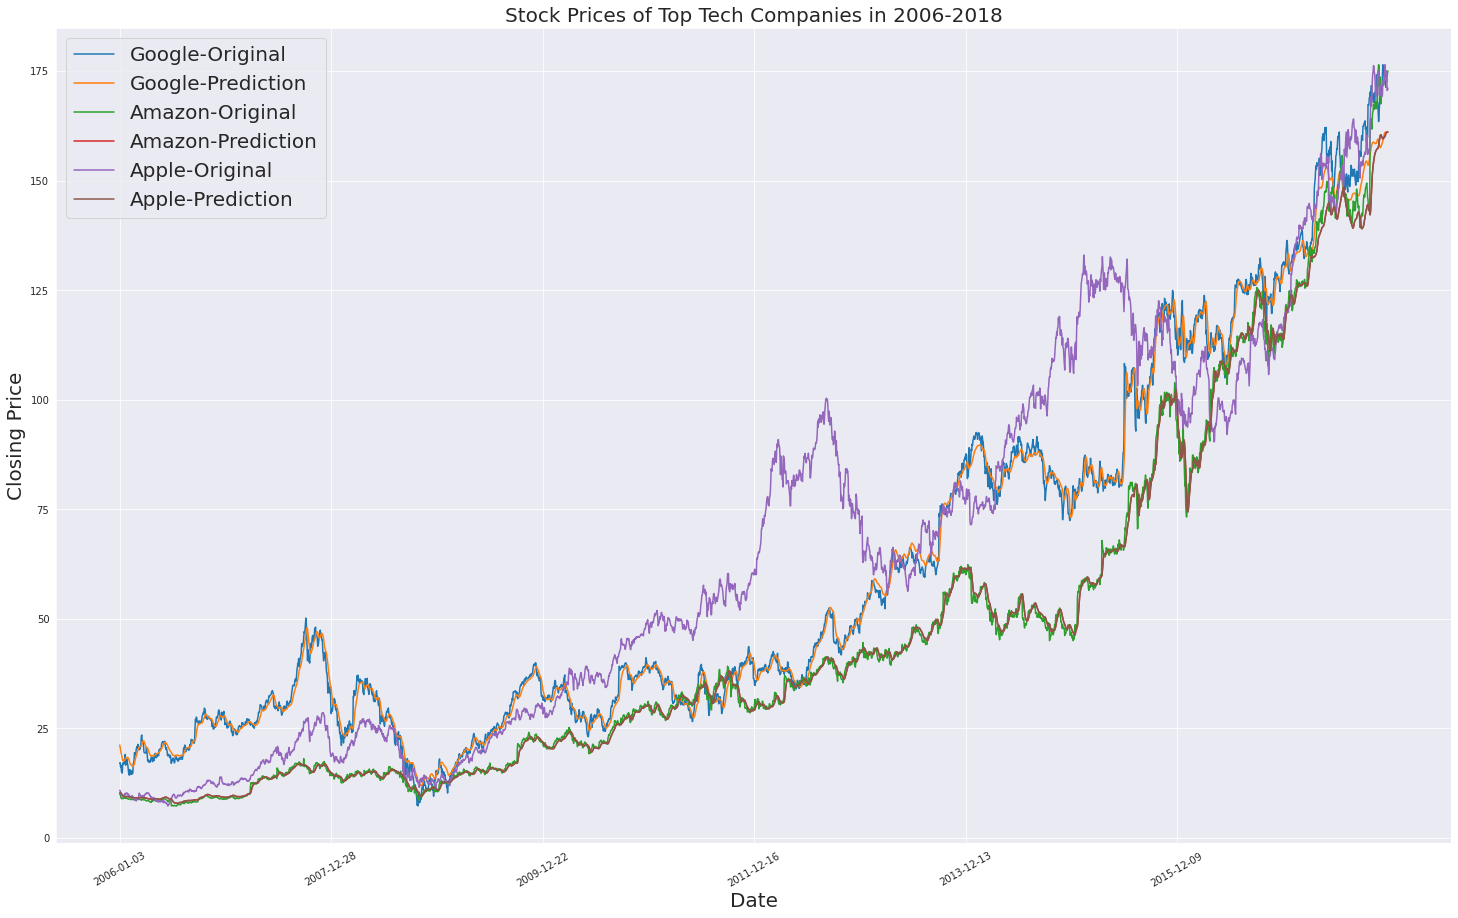

In [32]:
sns.set_style("darkgrid")
plt.figure(figsize = (25,15))
plt.plot(google_original,label='Google-Original')
plt.plot(google_predicted,label='Google-Prediction')

plt.plot(amazon_original,label='Amazon-Original')
plt.plot(amazon_predicted,label='Amazon-Prediction')


plt.plot(apple_original,label ='Apple-Original')
plt.plot(apple_predicted,label ='Apple-Prediction')

plt.xticks(range(0,google_original.shape[0],500),google_data['Date'].loc[::500],rotation=30)
plt.legend(prop={'size': 20})
plt.title("Stock Prices of Top Tech Companies in 2006-2018",fontdict={'fontsize':20})
plt.xlabel('Date',fontdict={'fontsize':20})
plt.ylabel('Closing Price',fontdict={'fontsize':20})
plt.show()